In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

## Задача
Относительно недавно (в 2018-м году) исследователи из Яндекса разработали классный метод анализа тестов над метриками-отношениями.

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR.

При этом метод сам по себе очень прост. Что это за метрика такая?

1. Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
2. осчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
3. После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  \
Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже).

Задача:

1. Проанализировать тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
2. Проанализировать тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [2]:
# Выгружаем пользователей, которые участвовали в A/B тесте из групп 1 и 2

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
SELECT
  exp_group,
  user_id,
  sum(action = 'like') as likes,
  sum(action = 'view') as views,
  likes / views as ctr
FROM
  simulator_20230720.feed_actions
WHERE
  toDate(time) between '2023-06-30'
  and '2023-07-06'
  and exp_group in (2, 1)
GROUP BY
  exp_group,
  user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [3]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596
...,...,...,...,...,...
19892,2,17146,0,10,0.000000
19893,1,30872,11,59,0.186441
19894,2,25383,42,127,0.330709
19895,2,139020,17,41,0.414634


In [5]:
# Вычисляем CTR в контрольной группе и расчитываем метрику линеаризованных лайков

ctr_control = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
df['linearized_likes'] = df['likes'] - ctr_control * df['views']

<Axes: xlabel='linearized_likes', ylabel='Count'>

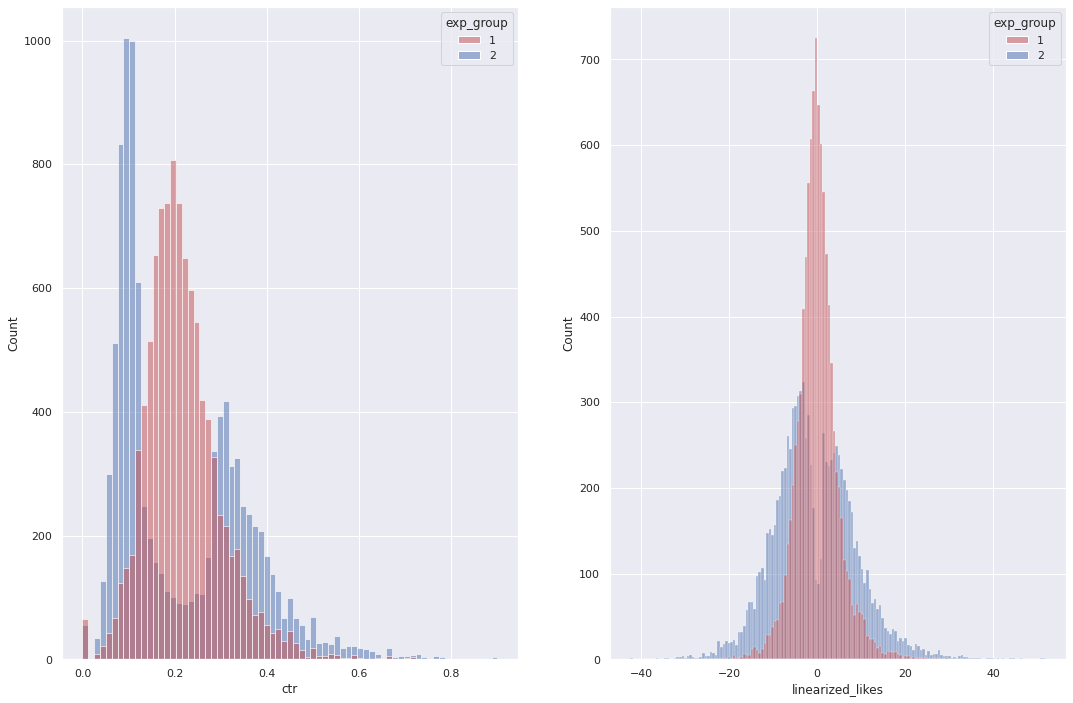

In [20]:
# Распределние CTR и лианеризованных лайков в наших группах

plt.subplot(1, 2, 1)
sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.subplot(1, 2, 2)
sns.histplot(data = df, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [8]:
# T-тест для новой метрики
stats.ttest_ind(df[df.exp_group == 1].linearized_likes,
                df[df.exp_group == 2].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=5.93637710193448, pvalue=2.9805064038668164e-09)

In [15]:
# T-тест для CTR
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Видно, что в T-тестах получаются принципиально разные результаты для групп 1 и 2. Когда мы сравнивали CTR, мы отвергли гипотезу о том, что новая система рекомендаций увеличивает CTR. Если же мы сравниваем новые метрики линеаризованных лайков, то получается p value сильно меньше 0.05 и мы бы приняли нашу гипотезу.


In [9]:
# Выгружаем пользователей, которые участвовали в A/B тесте из групп 0 и 3

q = """
SELECT
  exp_group,
  user_id,
  sum(action = 'like') as likes,
  sum(action = 'view') as views,
  likes / views as ctr
FROM
  simulator_20230720.feed_actions
WHERE
  toDate(time) between '2023-06-30'
  and '2023-07-06'
  and exp_group in (0, 3)
GROUP BY
  exp_group,
  user_id
"""

df1 = pandahouse.read_clickhouse(q, connection=connection)

In [10]:
df1

,exp_group,user_id,likes,views,ctr
0,3,115383,12,44,0.272727
1,3,123580,2,11,0.181818
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,6,25,0.240000
...,...,...,...,...,...
19917,3,13781,10,27,0.370370
19918,3,130651,18,98,0.183673
19919,0,3681,7,55,0.127273
19920,3,122008,5,41,0.121951


In [11]:
# Вычисляем CTR в контрольной группе и расчитываем метрику линеаризованных лайков

ctr_control = df1[df1.exp_group == 0].likes.sum()/df1[df1.exp_group == 0].views.sum()
df1['linearized_likes'] = df1['likes'] - ctr_control * df1['views']

<Axes: xlabel='linearized_likes', ylabel='Count'>

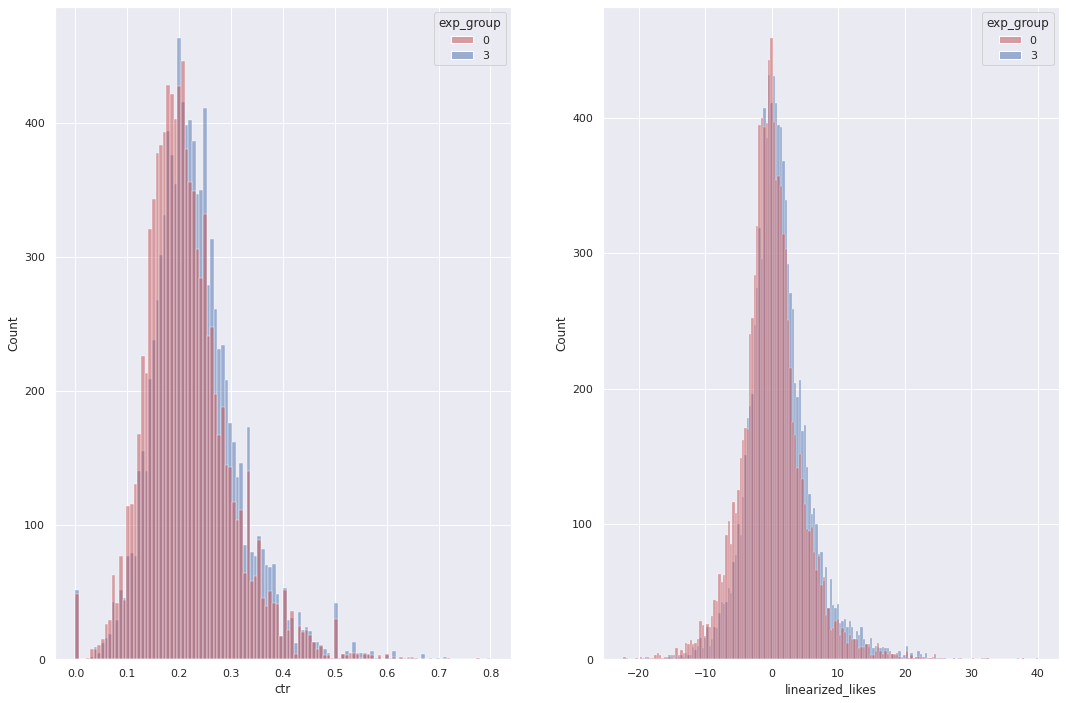

In [19]:
# Распределние CTR и лианеризованных лайков в наших группах

plt.subplot(1, 2, 1)
sns.histplot(data = df1, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.subplot(1, 2, 2)
sns.histplot(data = df1, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [12]:
# T-тест для новой метрики
stats.ttest_ind(df1[df1.exp_group == 0].linearized_likes,
                df1[df1.exp_group == 3].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=-16.186230032932844, pvalue=1.4918137745326139e-58)

In [14]:
# T-тест для CTR
stats.ttest_ind(df1[df1.exp_group == 0].ctr,
                df1[df1.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.935320516755773, pvalue=6.216047483062228e-44)

Видно, что T-тест по новой метрике работает несколько точнее чем просто по CTR. P value получились меньше. Хотя и в T-тесте для CTR p value было сильно меньше 0.05. В обоих случаю мы бы приняли нашу гипотезу.